# Using thermodynamic analysis to guide metabolic engineering
DO 12-6-2018  
Using Python 3 and eQuilibrator API  

DO 12-17-2018  
Looking at different ethanol ratios

DO 12-21-2018
Re-ran analysis with improved plotting dashboard from 'Analyzing_metabolites_DO.ipynb' 


In [1]:
import numpy as np
from numpy import array, eye, log, zeros
import pandas as pd
from equilibrator_api import Reaction, ComponentContribution, ReactionMatcher, CompoundMatcher, ParseError, Pathway
from equilibrator_api.bounds import Bounds
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

## Set up translator for KEGG IDs
Note: I set these up as dataframes because I was troubleshooting an issue with duplicate KEGG IDs. Eventually I think these should be set up as dictionaries, to make the code more readable

In [2]:
# set up the reaction bounds
# make a dataframe with the upper and lower bounds
def bounds_to_df(compounds, bounds):
    """
    Make a dataframe with concentrations
    Args:
        compounds = list of KEGG IDs
        bounds = equilibrator-api bounds object
    """
    boundsDf = pd.DataFrame(compounds, columns = ['Compound:Identifiers:kegg.compound']) # I had to choose this clunky column name to make it work with bounds.py 
                                                                                                    # from_dataframe method
    boundsDf['Name'] = boundsDf['Compound:Identifiers:kegg.compound'].apply(lambda x: kta.loc[x.lower()]) # add abbreviations
    boundsDf['Concentration:Max'] = boundsDf['Compound:Identifiers:kegg.compound'].apply(lambda x: bounds.GetUpperBound(x))
    boundsDf['Concentration:Min'] = boundsDf['Compound:Identifiers:kegg.compound'].apply(lambda x: bounds.GetLowerBound(x))
    return boundsDf

In [3]:
# make a dictionary to translate KEGG IDs into human-readable abbreviations
keggTranslatorDf = pd.read_excel('KEGG_SEED_DO.xls')
kt = keggTranslatorDf #short name for easier typing

# translate KEGG ID to abbreviation
kta = kt.loc[:,['KEGG ID(S)', 'ABBREVIATION']]
kta['KEGG ID(S)'] = kta['KEGG ID(S)'].str.lower() # set to lower case for better matching
kta['ABBREVIATION'] = kta['ABBREVIATION'].str.lower() # set to lower case for better matching
kta.set_index('KEGG ID(S)', inplace = True)

# translate abbreviation to KEGG ID
atk = kt.loc[:,['ABBREVIATION', 'KEGG ID(S)']].sort_values(by = ['KEGG ID(S)'], ascending = True)
atk['KEGG ID(S)'] = atk['KEGG ID(S)'].str.lower() # set to lower case for better matching
atk['ABBREVIATION'] = atk['ABBREVIATION'].str.lower() # set to lower case for better matching
atk = atk.groupby('ABBREVIATION').first() # take the first KEGG ID in each group

atkDict = dict(zip(atk.index, atk['KEGG ID(S)'].str.upper()))
ktaDict = dict(zip(kta.index.str.upper(), kta['ABBREVIATION'].values))

## Set up model
* Choose reactions
* Set fluxes
* Set concentration bounds
* Set pH and ionic strength

In [4]:
# need to declare pH and ionic strength constants at the beginning
# they are used in the make_pathway function
modelFileName = 'cth_thermo_model_DO_SD2.xlsx'
PH = 7.0
IS = 0.1

# load stoichiometric model from Excel file
allRxnDf = pd.read_excel(modelFileName, # using Satya's version
                         sheet_name = 'reactions')
# make list of flux sets from excel file column names
# all of the column names from 'ppi-pfk' to 'mal-gapn' inclusive
fluxSets = allRxnDf.loc[:,'ppi-pfk':].columns.values 

# load bounds information from the model
boundsDf = pd.read_excel(modelFileName, # using Satya's version
                         sheet_name = 'metabolite_bounds')
allRxnDf[:5]

,Name,PlaintextFormula,AbbreviationFormula,KeggFormula,Notes,ppi-pfk,atp-pfk,mal-snt,pdc,gapn,pyk,aldh-ndp,adh-ndp,mal-gapn,tsac
0,CBtx,H2O + ATP <=> ADP + Phosphate,h2o + atp <=> adp + pi,C00001 + C00002 <=> C00008 + C00009,ATP hydrolysis for cellobiose transport,1,1,1,1,1,1,1,1,1,1
1,CBP,Phosphate + Cellobiose <=> D-Glucose + Glucose...,pi + cellb <=> glc-D + g1p,C00009 + C00185 <=> C00031 + C00103,NaN,1,1,1,1,1,1,1,1,1,0
2,BGL,Cellobiose + H2O <=> 2 D-Glucose,cellb + h2o <=>2 glc-D,C00185 + C00001 <=> 2 C00031,Beta glucosidase,0,0,0,0,0,0,0,0,0,1
3,GLK-GTP,D-Glucose + GTP <=> D-Glucose-6-phosphate + GDP,glc-D + gtp <=> g6p + gdp,C00031 + C00044 <=> C00092 + C00035,NaN,1,1,1,1,1,1,1,1,1,0
4,GLK-ATP,D-Glucose + ATP <=> D-Glucose-6-phosphate + ADP,glc-D + atp <=> g6p + adp,C00031 + C00002 <=> C00092 + C00008,NaN,0,0,0,0,0,0,0,0,0,2


In [20]:
def set_model_bounds(bounds, modelBounds = []):
    """
    Given a bounds object, set bounds for selected metabolites. Assume that 
    boundsDf has already been created from the 'metabolite_bounds' tab from
    the model file
    
    Args:
       modelBounds: a list of KEGG IDs for metabolites to set bounds data based on the model
    """
    # load bounds information from the model
    boundsDf = pd.read_excel(modelFileName, sheet_name = 'metabolite_bounds')
    
    for cid in modelBounds:
        lb = boundsDf.loc[boundsDf['KEGG_ID'] == cid, 'Concentration:Min'].iloc[0]
        ub = boundsDf.loc[boundsDf['KEGG_ID'] == cid, 'Concentration:Max'].iloc[0]
        bounds.SetBounds(cid, lb, ub)
        
    return bounds
    

In [5]:
def make_pathway(fluxSet, allRxnDf):
    """
    Given a fluxSet name, return the parsed pathway object
    
    Args:
       fluxSet: is the name of a column in the Excel model file
       allRxnDf: a dataframe with the model reactions
    """
    # choose a flux set, and drop all of the zero-flux reactions
    selectedRxnDf = allRxnDf.loc[allRxnDf[fluxSet] != 0, ['Name', 'AbbreviationFormula', 'KeggFormula', fluxSet]]
    selectedRxnDf.rename(columns = {fluxSet:'flux'}, inplace = True) # rename the flux columns to 'flux' to simplify subsequent
                                                                     # processing
    #selectedRxnDf
    # parse the KeggFormula column to create eQuilibrator Reaction objects
    # create reaction list
    reactions = []
    for i, row in selectedRxnDf.iterrows():
        rxn = Reaction.parse_formula(row['KeggFormula'], rid = row['Name'])
        if (rxn.check_full_reaction_balancing()):
            reactions.append(rxn)
        else:
            print('Error: reaction {} is not balanced'.format(row['AbbreviationFormula']))

    # create flux list
    fluxes = selectedRxnDf['flux'].values

    # calculate dGO_r_primes
    dG0_r_primes = []
    for r in reactions:
        result = r.dG0_prime(pH = PH, ionic_strength = IS)
        #print(result)
        dG0_r_primes.append(result)

    # set up the model
    pp = Pathway(reactions = reactions, fluxes = fluxes, dG0_r_primes = dG0_r_primes)
    return pp

## Set up plotting

In [6]:
def get_model_description(pp):
    """
    Given an equilibrator-api pathway object, determine the net reaction 
    and dG0 and format into a string
    """
    rm = ReactionMatcher()
    dG0p = pp.net_reaction().dG0_prime() # float
    rnxTxt = rm.write_text_formula(pp.net_reaction())
    netRxnTxt = '∆G0={0:.2f}\n{1}'.format(dG0p, rnxTxt)
    return netRxnTxt

In [7]:
def calculate_cofactor_ratios(compDf):
    """
    Given a dataframe with concentration values, calculate key cofactor ratios
    Return a dataframe with those ratios
    """

    concDf = compDf.concentration
    serList = []
    serListNames = []

    # calculate ATP/ADP ratio
    if len(concDf.loc[concDf.index.isin(['atp', 'adp'])]) == 2: # make sure both values are present
        atpRatio = concDf.loc['atp']/concDf.loc['adp']
        serList.append(atpRatio)
        serListNames.append('ATP/ADP Ratio')

    # calculate GTP/GDP ratio
    if len(concDf.loc[concDf.index.isin(['gtp', 'gdp'])]) == 2: # make sure both values are present
        gtpRatio = concDf.loc['gtp']/concDf.loc['gdp']
        serList.append(gtpRatio)
        serListNames.append('GTP/GDP Ratio')

    # calculate PPi/Pi ratio
    if len(concDf.loc[concDf.index.isin(['ppi', 'pi'])]) == 2: # make sure both values are present
        ppiRatio = concDf.loc['ppi']/concDf.loc['pi']
        serList.append(ppiRatio)
        serListNames.append('PPi/Pi Ratio')

    # calculate NAD/NADH ratio
    if len(concDf.loc[concDf.index.isin(['nad', 'nadh'])]) == 2: # make sure both values are present
        nadRatio = concDf.loc['nad']/concDf.loc['nadh']
        serList.append(nadRatio)
        serListNames.append('NAD/NADH Ratio')

    # calculate NADP/NADPH ratio
    if len(concDf.loc[concDf.index.isin(['nadp', 'nadph'])]) == 2: # make sure both values are present
        nadpRatio = concDf.loc['nadp']/concDf.loc['nadph']
        serList.append(nadpRatio)
        serListNames.append('NADP/NADPH Ratio')

    # calculate Fd(ox)/Fd(red) ratio
    if len(concDf.loc[concDf.index.isin(['fdxrd', 'fdxox'])]) == 2: # make sure both values are present
        fdxRatio = concDf.loc['fdxox']/concDf.loc['fdxrd']
        serList.append(fdxRatio)
        serListNames.append('Fd(ox)/Fd(red) Ratio')

    df = pd.DataFrame(serList, index = serListNames)
    return df

In [27]:
# function for plotting the results
def make_plots(fluxSet,  mdf_values, groupId, compDf, rxnDf, netRxns, 
               savePdf = False, xlabels = [], measuredBounds = [], modelBounds = []):
    """
    Plot the results of the thermodynamic analysis
    Args:
      fluxSet: the name of the set being plotted, also uses this to get the right net reaction info
      mdf_values: list of floats for making the mdf plot
      groupId: x-axis values
      compDf: combined dataframe with compound information
      rxnDf: combined dataframe with reaction information
      netRxns: list of strings that describe each fluxSet
      savePdf: flag for saving the output to a PDF file
      xlabels: list of strings for labeling x-axis
      measuredBounds: list of KEGG IDs of bounds that were specified by measured metabolite data
      modelBounds: list of KEGG IDs of bounds that were specified by the excel model file
    """
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec

    fig = plt.figure( figsize=(20,15))
    fig.suptitle('Analysis of flux set: {}'.format(fluxSet), fontsize=16, )
    plt.figtext(x=0, y=0.95, s=netRxns[fluxSet], fontsize=10, wrap = True)
    gs = GridSpec(6,2, figure=fig)

    ax1 = fig.add_subplot(gs[0, 0]) # for MDF plot
    ax2 = fig.add_subplot(gs[1:3, 1]) # rxn shadow price plot
    ax3 = fig.add_subplot(gs[3:, 0]) # metabolite concentrations
    ax4 = fig.add_subplot(gs[3:, 1]) # metabolite shadow prices
    ax5 = fig.add_subplot(gs[1:3, 0]) # dG values
    ax6 = fig.add_subplot(gs[0,1]) # for cofactor ratio plots
    
    # MDF plot
    ax1.plot(groupId, mdf_values, '-o')
    ax1.set_title('MDF vs metabolite set')
    ax1.set_ylabel('MDF')
    ax1.set_xlabel('EtOH conc (M)')
    ax1.set_xscale('log')
    if(len(xlabels) >0):
        ax1.set_xticks(groupId)
        ax1.set_xticklabels(xlabels, rotation = 90)
    ax1.axhline(y=0, color='r', linestyle='--')
    
    # cofactor ratio plot
    df = calculate_cofactor_ratios(compDf)
    sns.heatmap(df, linewidths = 0.05, ax = ax6, cmap='coolwarm', fmt = '.1f', annot = True, 
                annot_kws={'size':8})
    ax6.set_title('Cofactor Ratios')
    ax6.set_ylabel('Ratio')
    ax6.set_xlabel('EtOH conc (M)')
    if(len(xlabels) >0):
        ax5.set_xticklabels(xlabels, rotation = 90)
    
    # reaction dG
    dGRange = max(list(map(abs, mdf_values)))
    df = rxnDf.loc[:, 'dGr']
    sns.heatmap(df, linewidths = 0.05, ax = ax5, cmap='coolwarm', fmt = '.1f', annot = True, 
                annot_kws={'size':8}, vmin=-1*dGRange, vmax=dGRange)
    ax5.set_title('dGr')
    ax5.set_ylabel('Reaction')
    ax5.set_xlabel('EtOH conc (M)')
    if(len(xlabels) >0):
        ax5.set_xticklabels(xlabels, rotation = 90)
        
    # reaction shadow price plot
    df = rxnDf.loc[:, 'shadow_price']
    sns.heatmap(df, linewidths = 0.05, ax = ax2, cmap='coolwarm', fmt = '.1f', annot = True, 
                annot_kws={'size':8}, vmin=-1, vmax=1)
    ax2.set_title('Reaction Shadow Price')
    ax2.set_ylabel('Reaction')
    ax2.set_xlabel('EtOH conc (M)')
    if(len(xlabels) >0):
        ax2.set_xticklabels(xlabels, rotation = 90)
    
    # concentration plot
    df = compDf.loc[:, 'concentration'].apply(np.log10)
    sns.heatmap(df, ax = ax3, cmap='coolwarm', linewidths = 0.05, fmt = '.1f', annot = True, annot_kws={'size':8},
               vmin=-6, vmax=-2)
    ax3.set_title('Log Concentration')
    ax3.set_ylabel('Metabolite')
    ax3.set_xlabel('EtOH conc (M)')
    if(len(xlabels) >0):
        ax3.set_xticklabels(xlabels, rotation = 90)

    # metabolite shadow price plot
    df = compDf.loc[:, 'shadow_price'] #.apply(np.log10)
    sns.heatmap(df, ax = ax4, cmap='coolwarm', linewidths = 0.05, fmt = '.1f', annot = True, annot_kws={'size':8},
               vmin=-2, vmax=2)
    ax4.set_title('Metabolite Shadow Price')
    ax4.set_ylabel('Metabolite')
    ax4.set_xlabel('EtOH conc (M)')
    if(len(xlabels) >0):
        ax4.set_xticklabels(xlabels, rotation = 90)

        
    # color metabolites by how they were constrained (i.e. default bounds, bounds from measured metabolite data or bounds from model)
    for ax in [ax3, ax4]:
        ytl = ax.get_yticklabels()
        for label in ytl:
            name = label.get_text()
            cid = atkDict[name] # translate metabolite abbreviation to KEGG ID

            # if the bounds come from measured data, change the label color
            if cid in measuredBounds:
                label.set_color('green')

            # if the bounds come from the model, change the label to a different color
            if cid in modelBounds:
                label.set_color('darkorange')
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    
    # save the results as a PDF if that flag is set to True
    if savePdf:
        plt.savefig('etoh_conc_{}.pdf'.format(fluxSet), bbox_inches = "tight")
    
    return fig

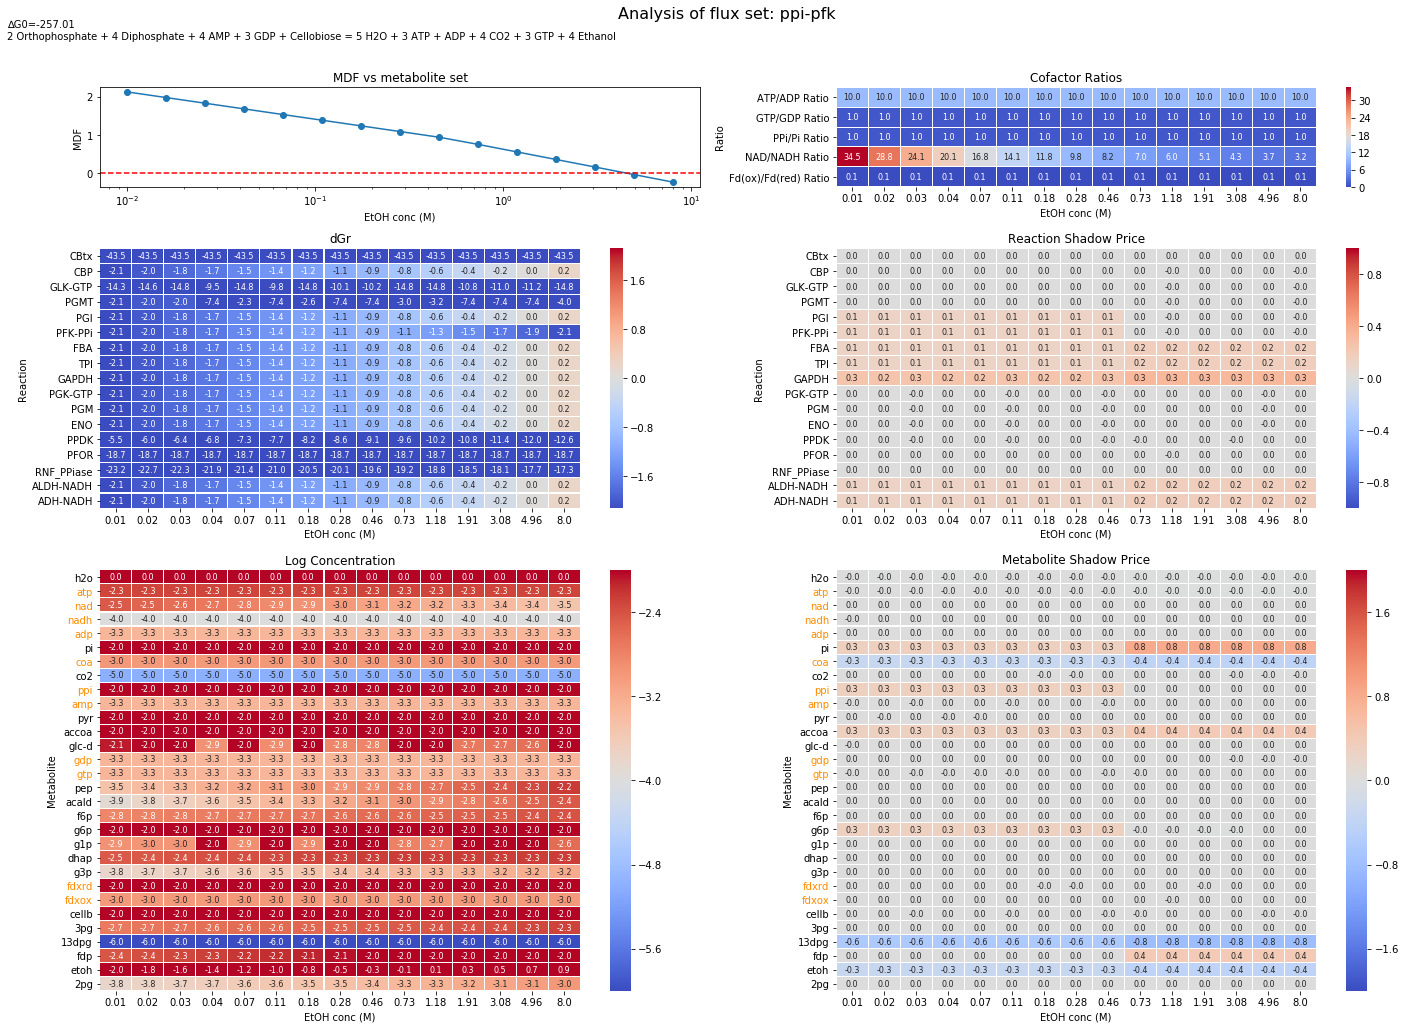

In [29]:
## for testing plotting function
# plot the results
myFig = make_plots('ppi-pfk', mdf_values, et_conc, 
               compDf, rxnDf, netRxns, savePdf = False, xlabels = [], 
               modelBounds = getBoundsFromModel, measuredBounds = [])

## Analyze all flux sets




********* Working on flux set ppi-pfk ************
ethanol conc = 0.01, NAD/NADH ratio = 34.46
ethanol conc = 0.02, NAD/NADH ratio = 28.81
ethanol conc = 0.03, NAD/NADH ratio = 24.09
ethanol conc = 0.04, NAD/NADH ratio = 20.14
ethanol conc = 0.07, NAD/NADH ratio = 16.84
ethanol conc = 0.11, NAD/NADH ratio = 14.08
ethanol conc = 0.18, NAD/NADH ratio = 11.77
ethanol conc = 0.28, NAD/NADH ratio = 9.84
ethanol conc = 0.46, NAD/NADH ratio = 8.23
ethanol conc = 0.73, NAD/NADH ratio = 6.99
ethanol conc = 1.18, NAD/NADH ratio = 5.96
ethanol conc = 1.91, NAD/NADH ratio = 5.08
ethanol conc = 3.08, NAD/NADH ratio = 4.34
ethanol conc = 4.96, NAD/NADH ratio = 3.70
ethanol conc = 8.00, NAD/NADH ratio = 3.15



********* Working on flux set atp-pfk ************
ethanol conc = 0.01, NAD/NADH ratio = 29.27
ethanol conc = 0.02, NAD/NADH ratio = 24.97
ethanol conc = 0.03, NAD/NADH ratio = 21.29
ethanol conc = 0.04, NAD/NADH ratio = 18.16
ethanol conc = 0.07, NAD/NADH ratio = 15.49
ethanol conc = 0.11,

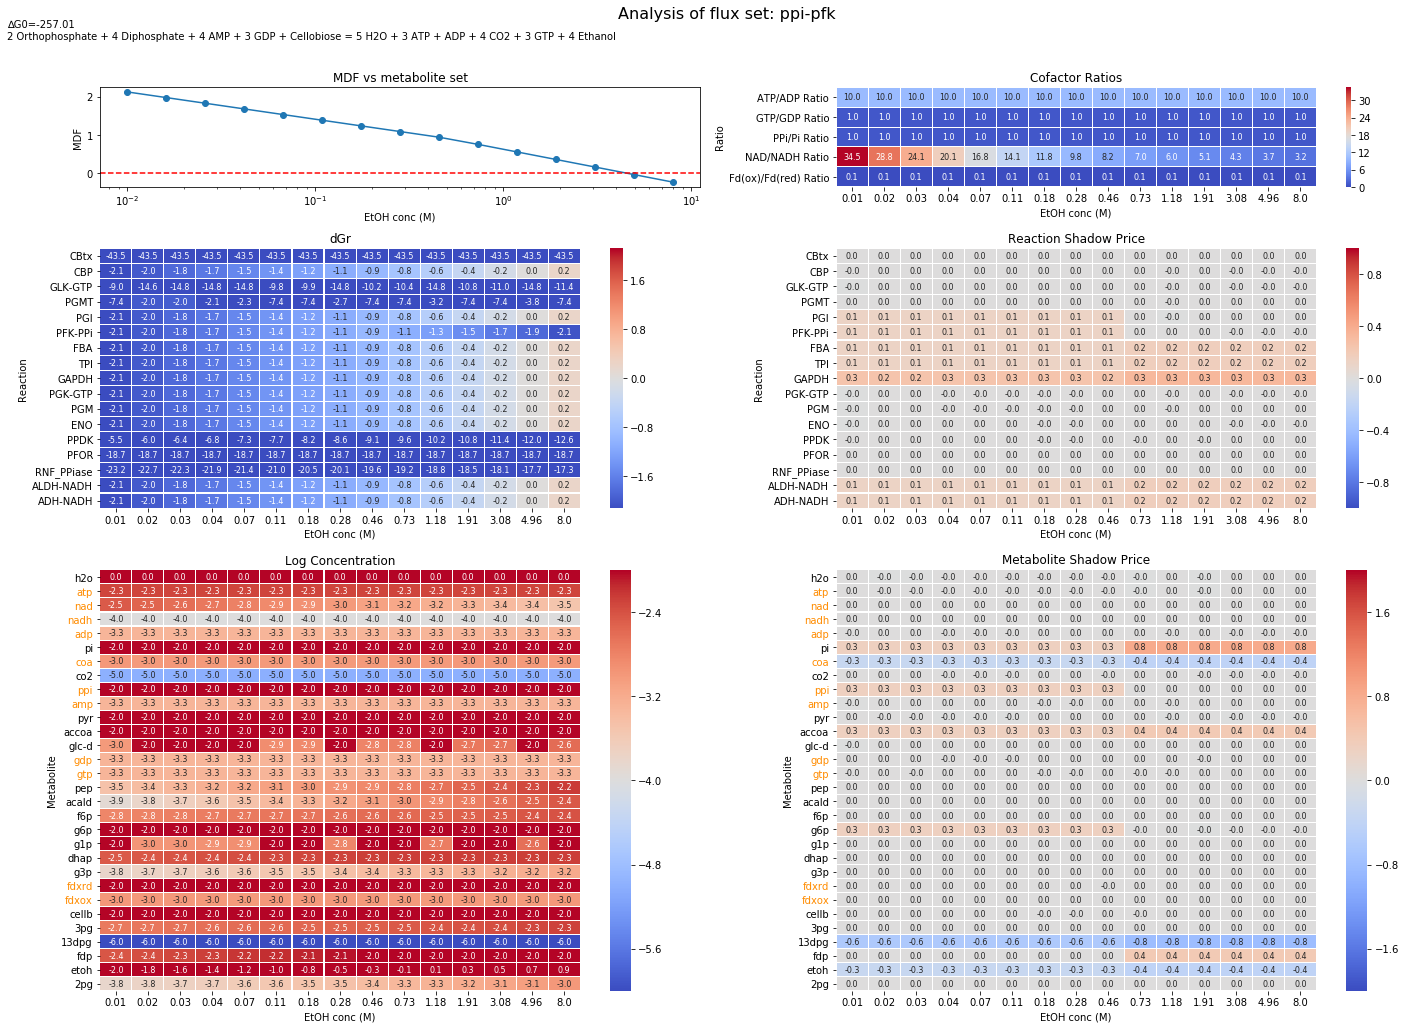

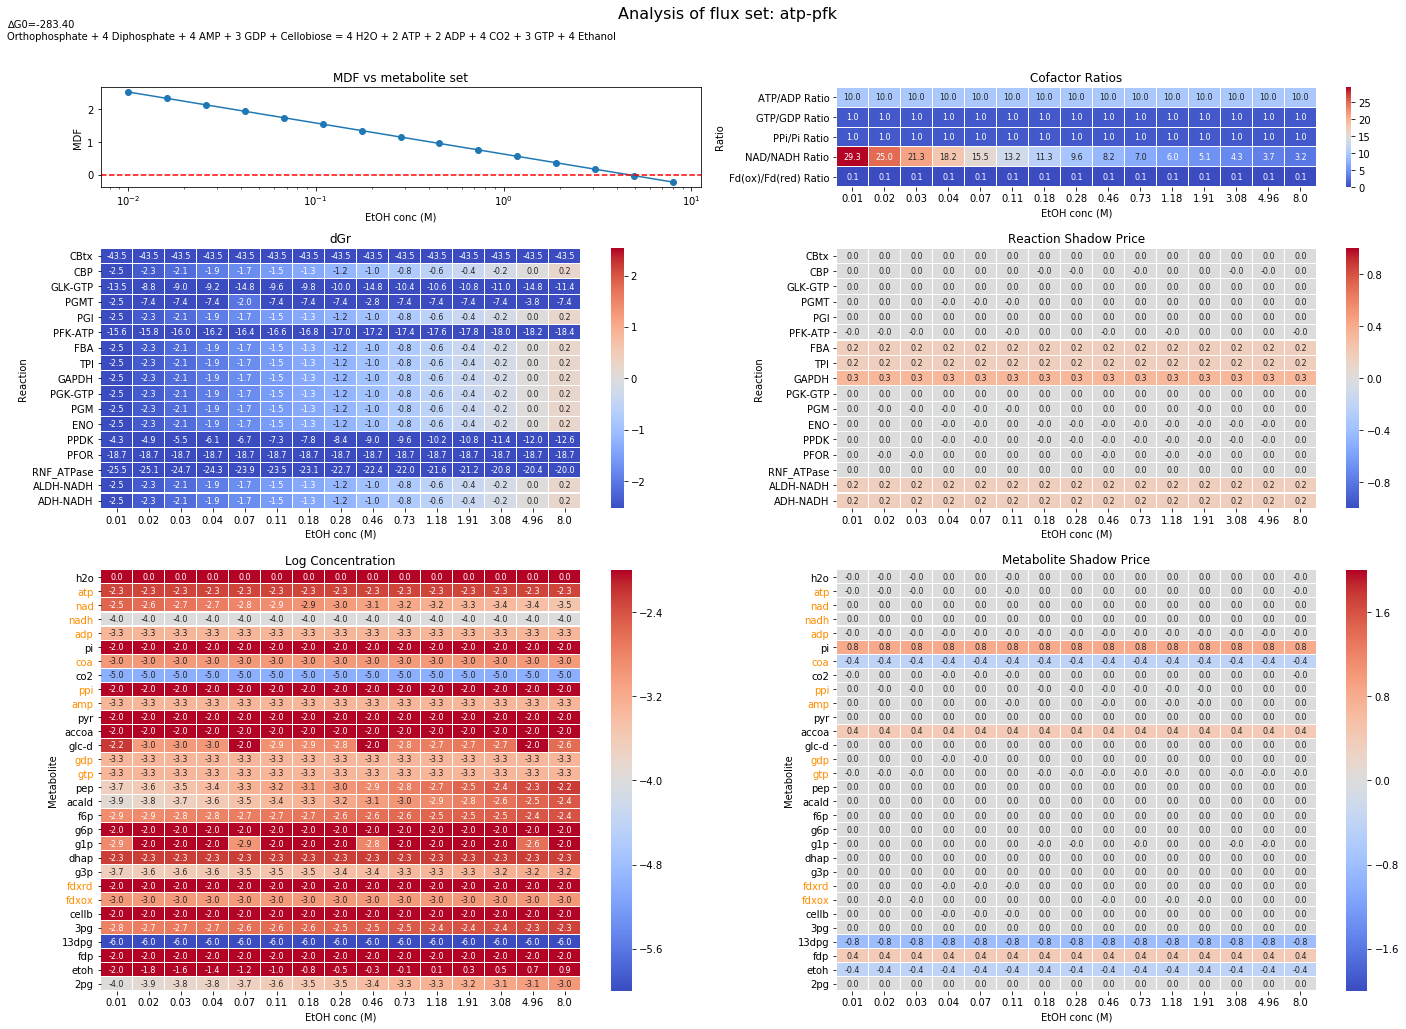

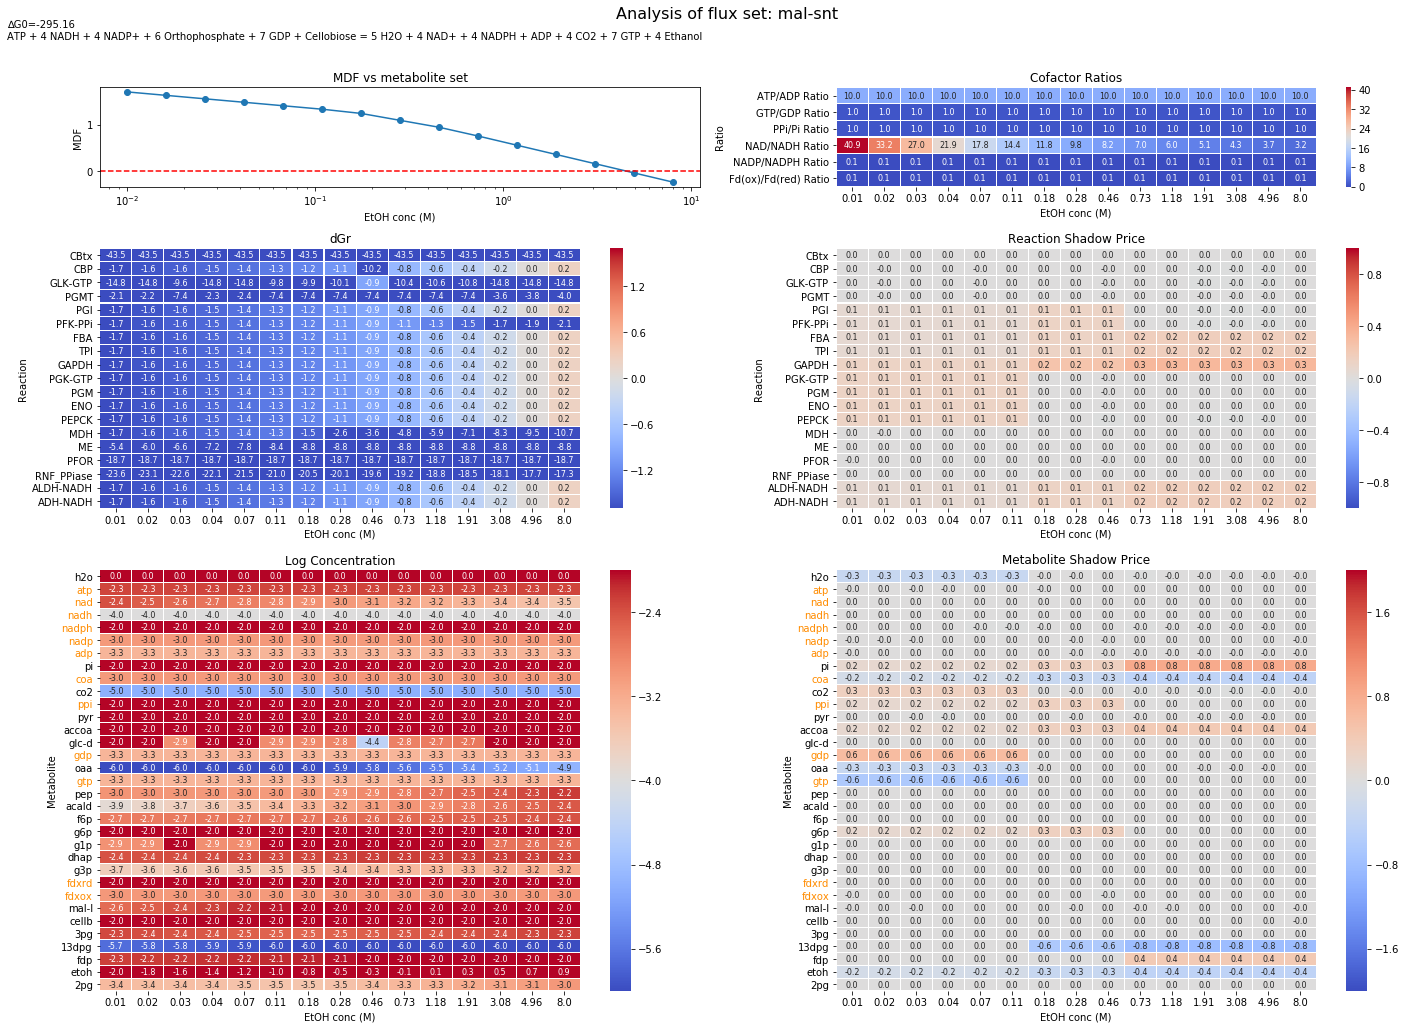

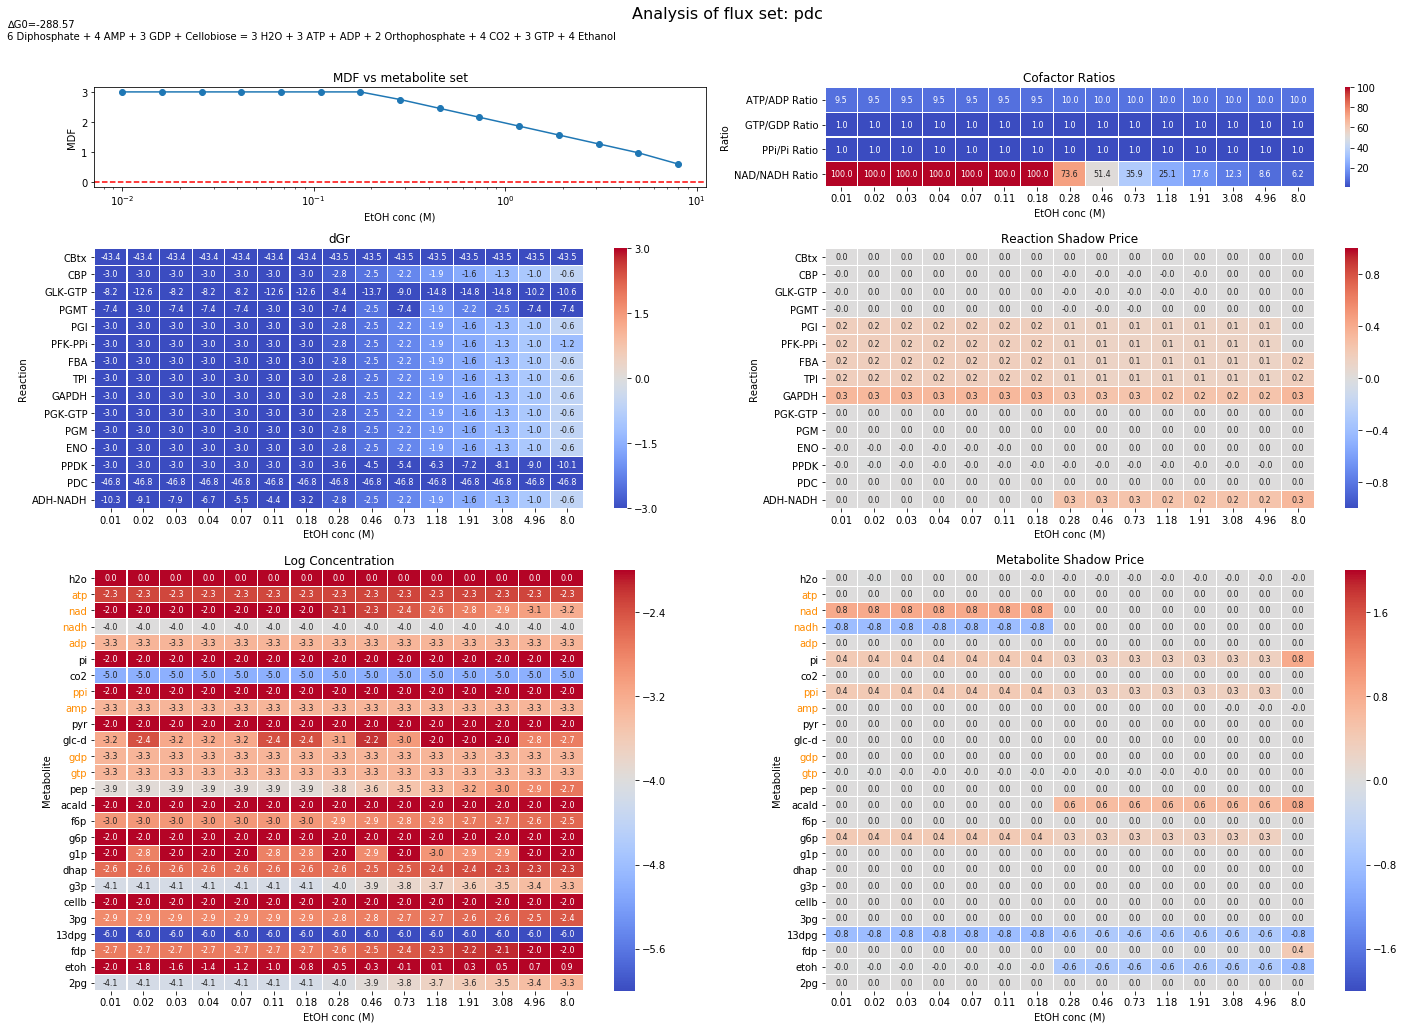

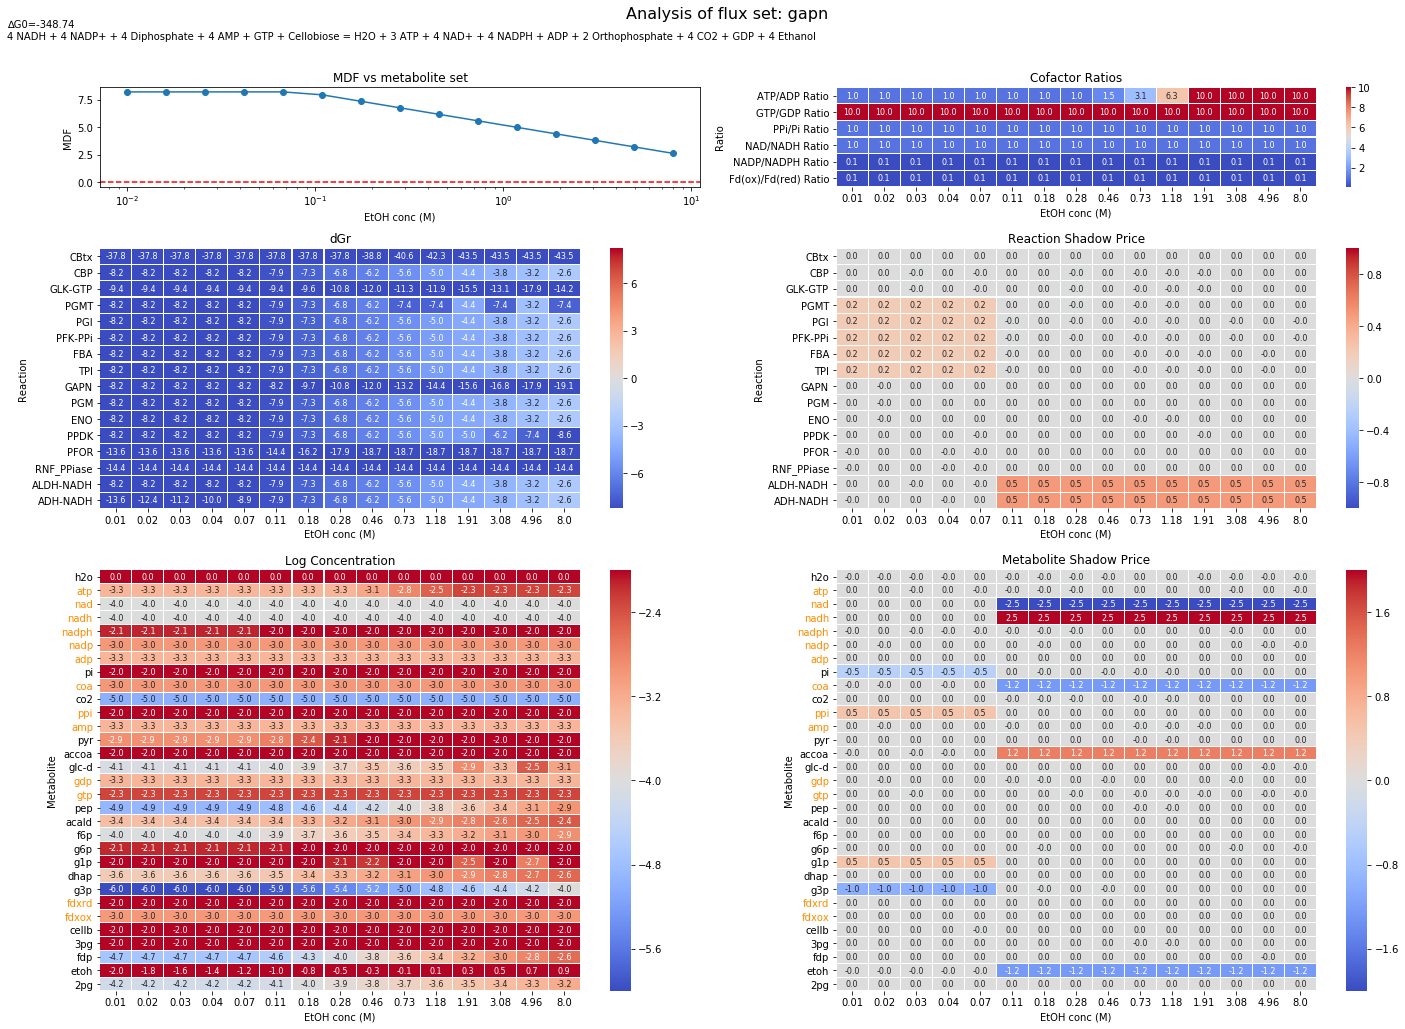

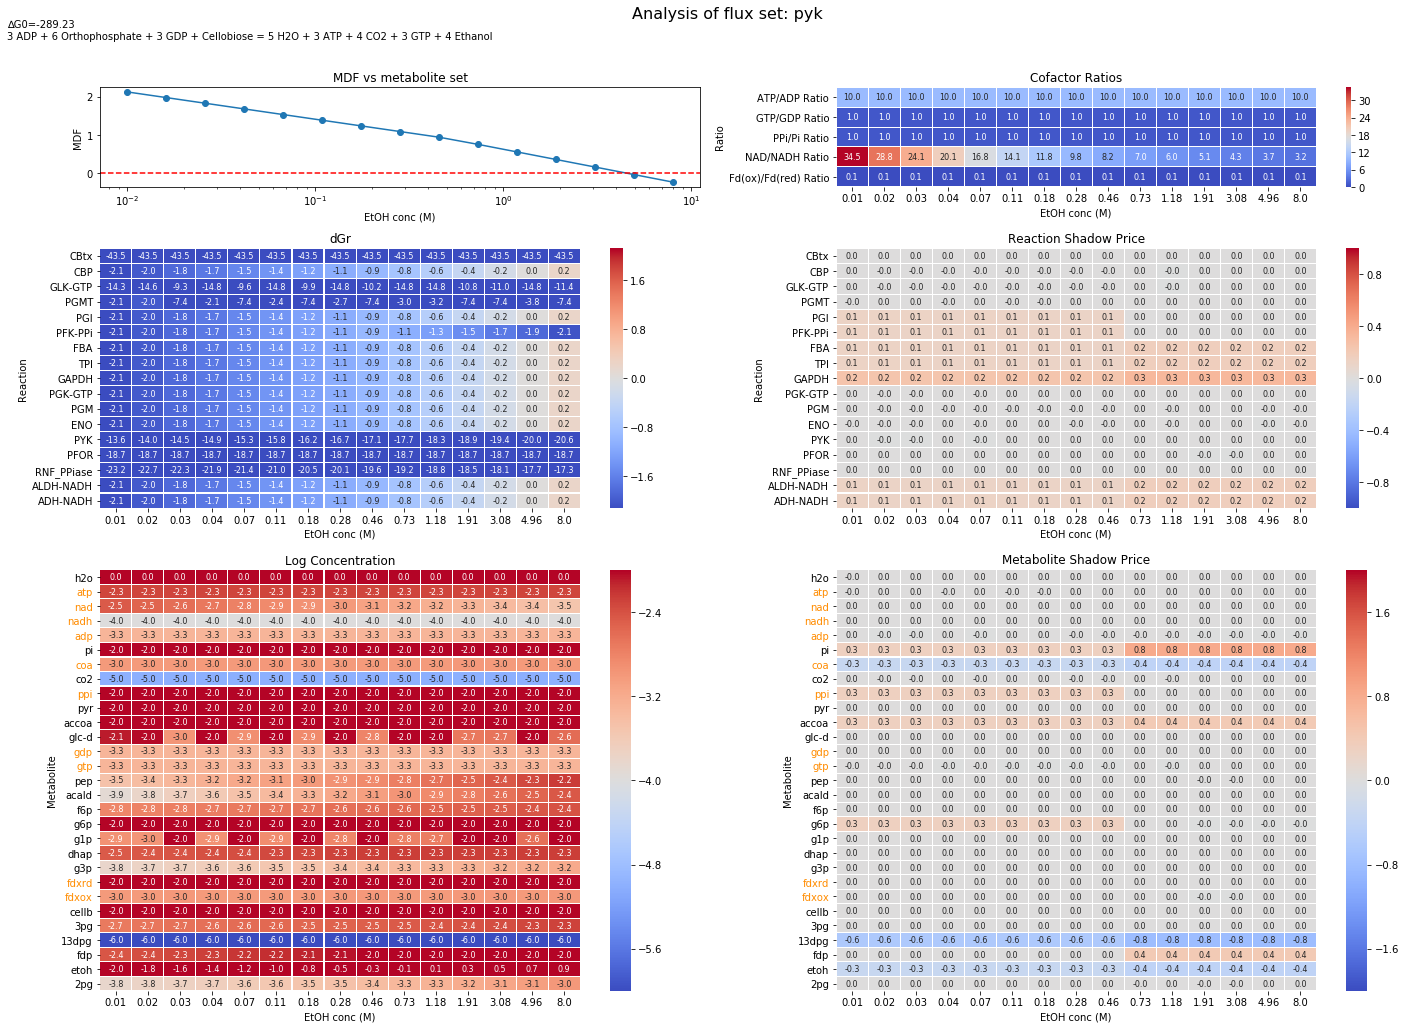

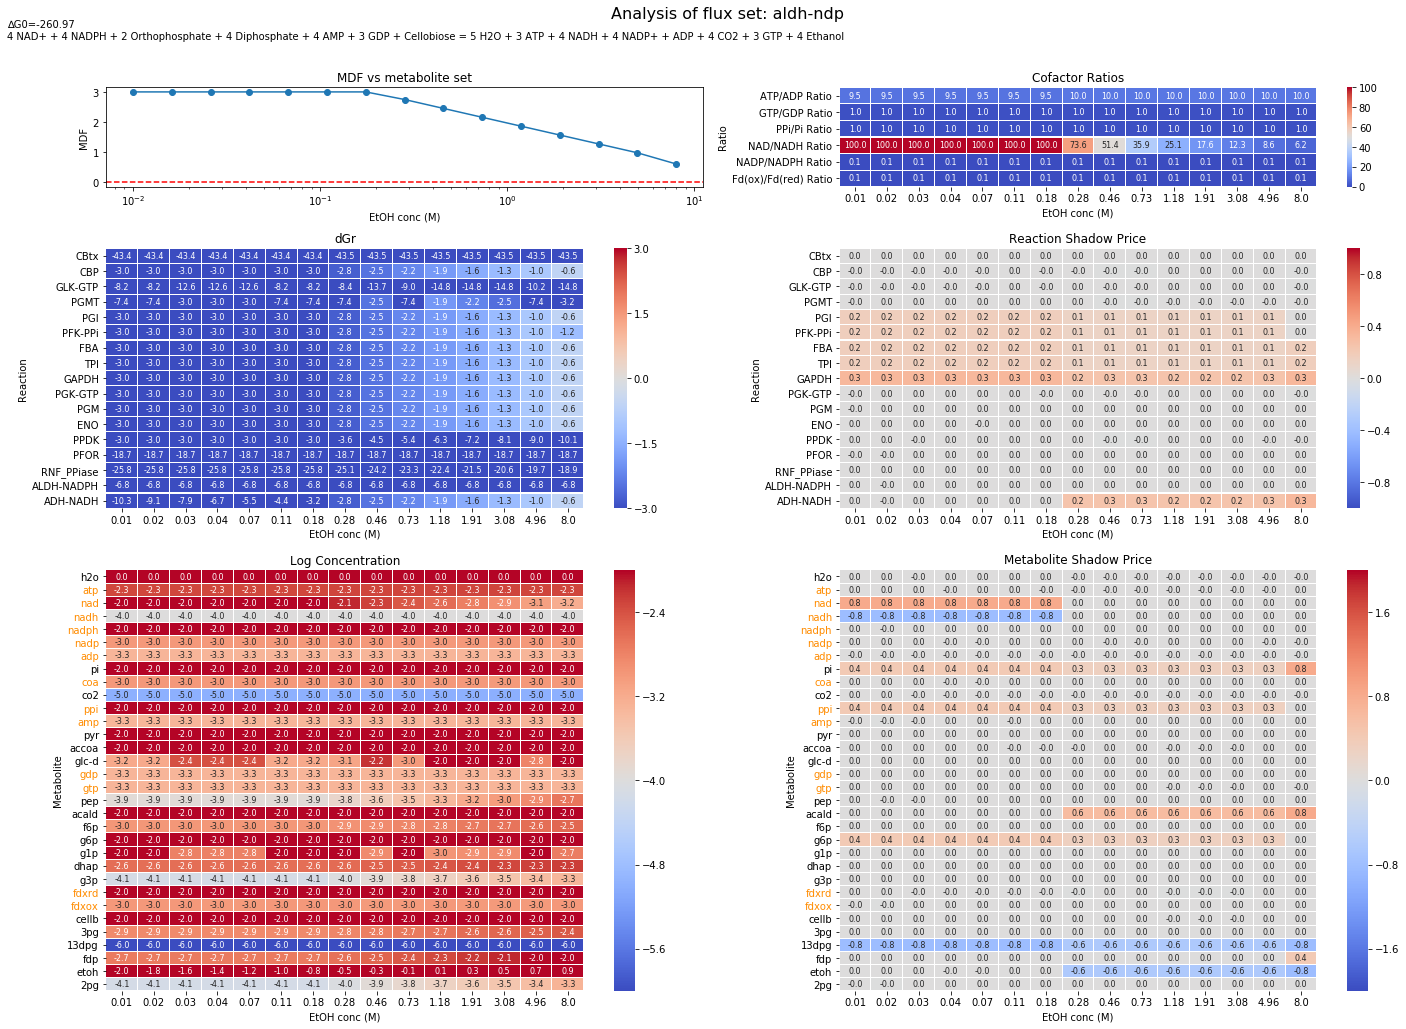

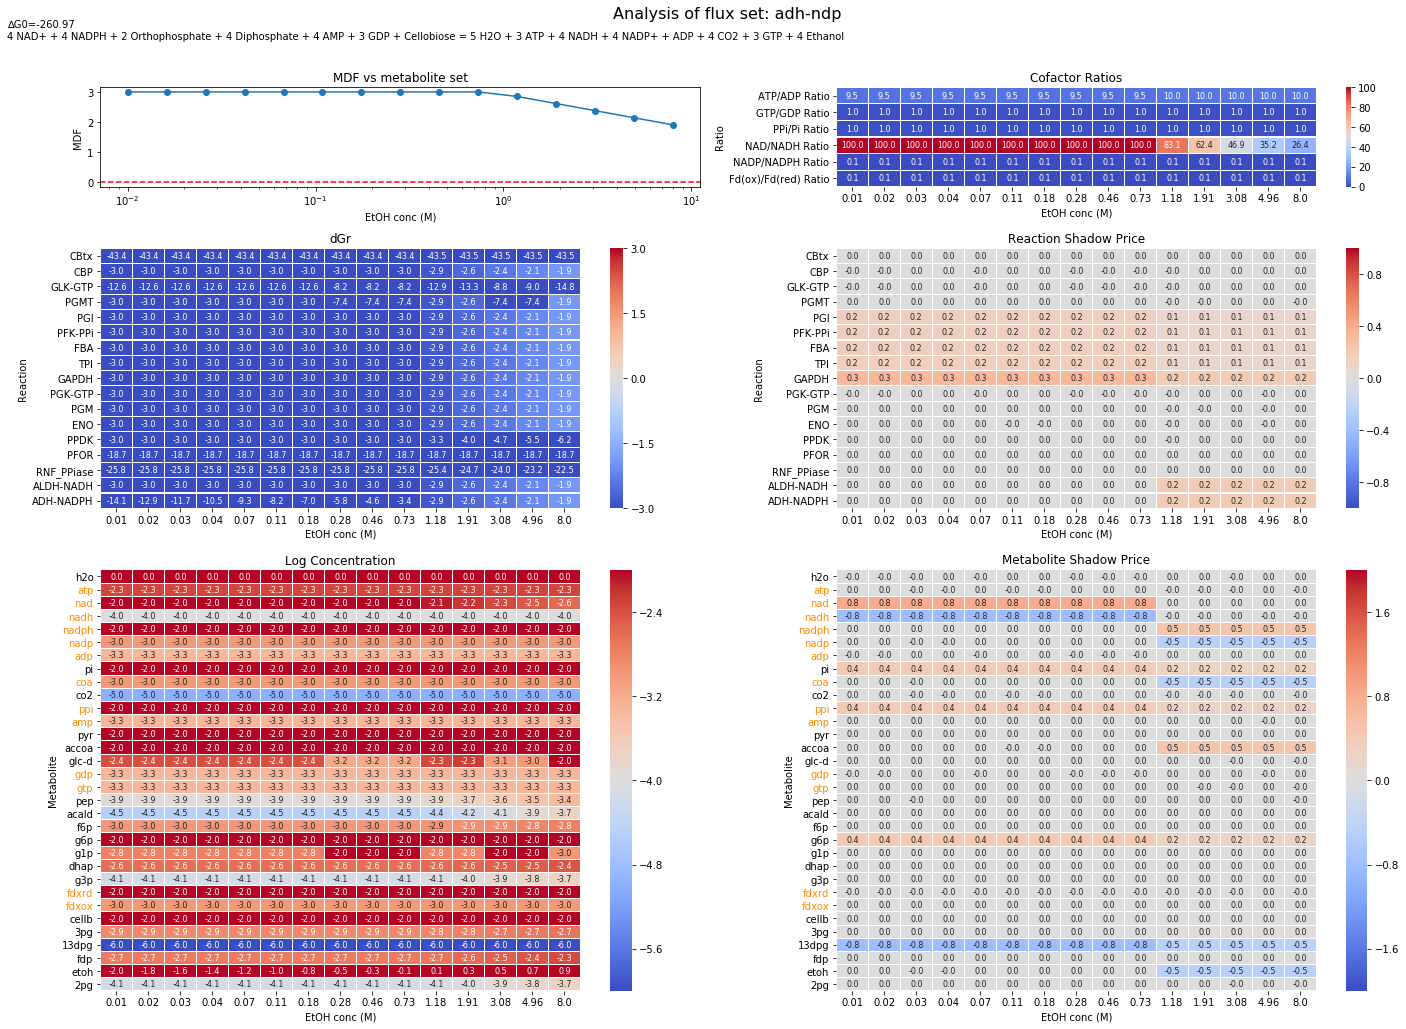

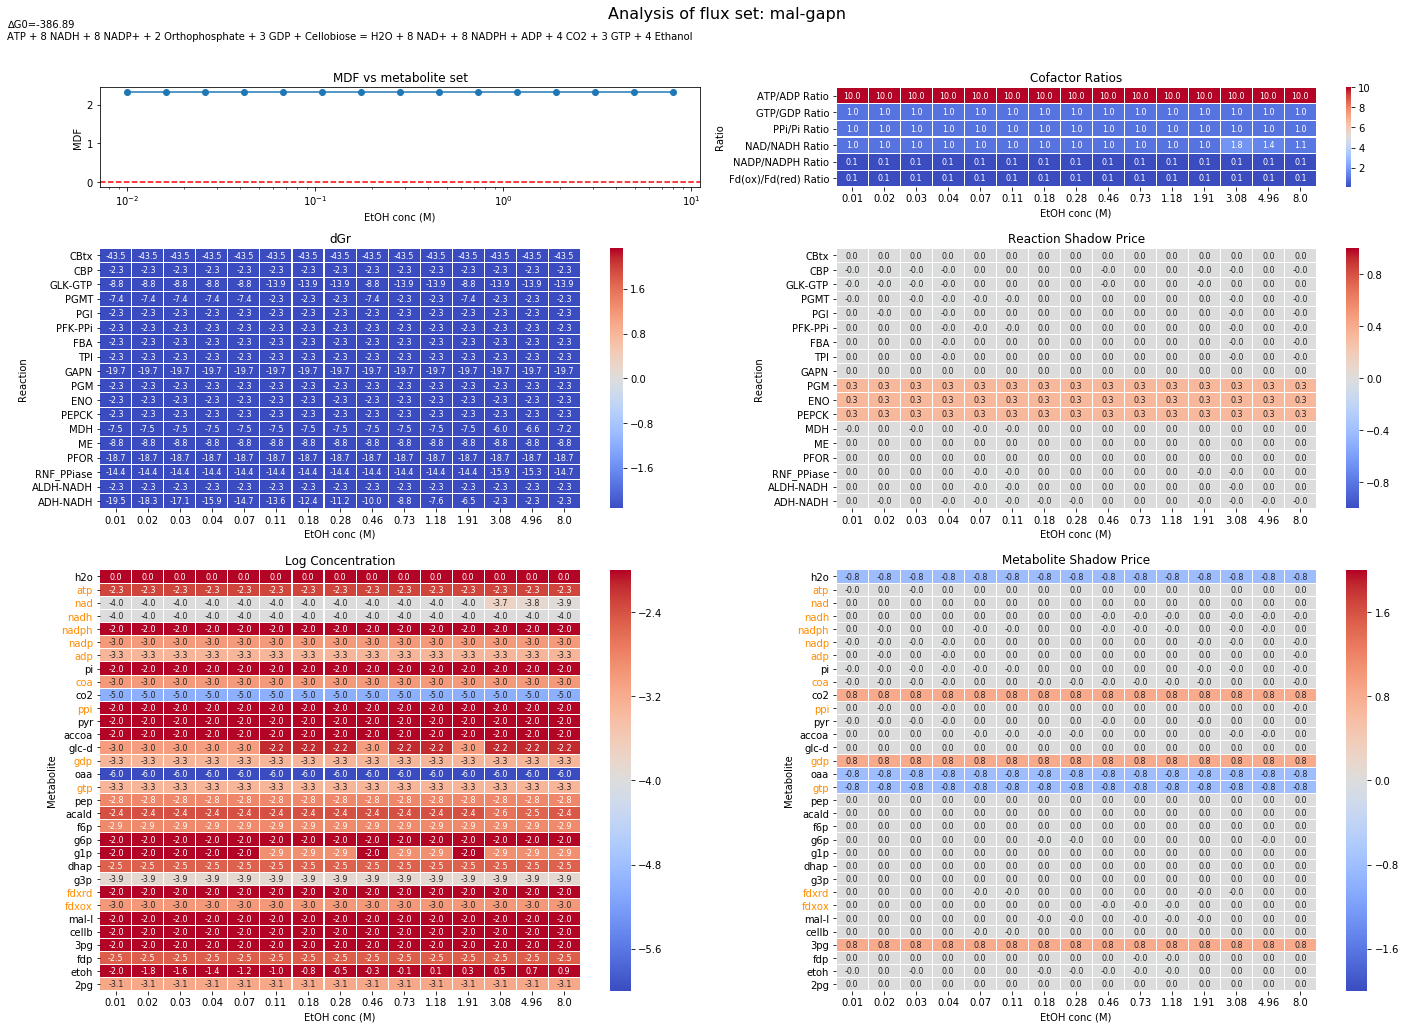

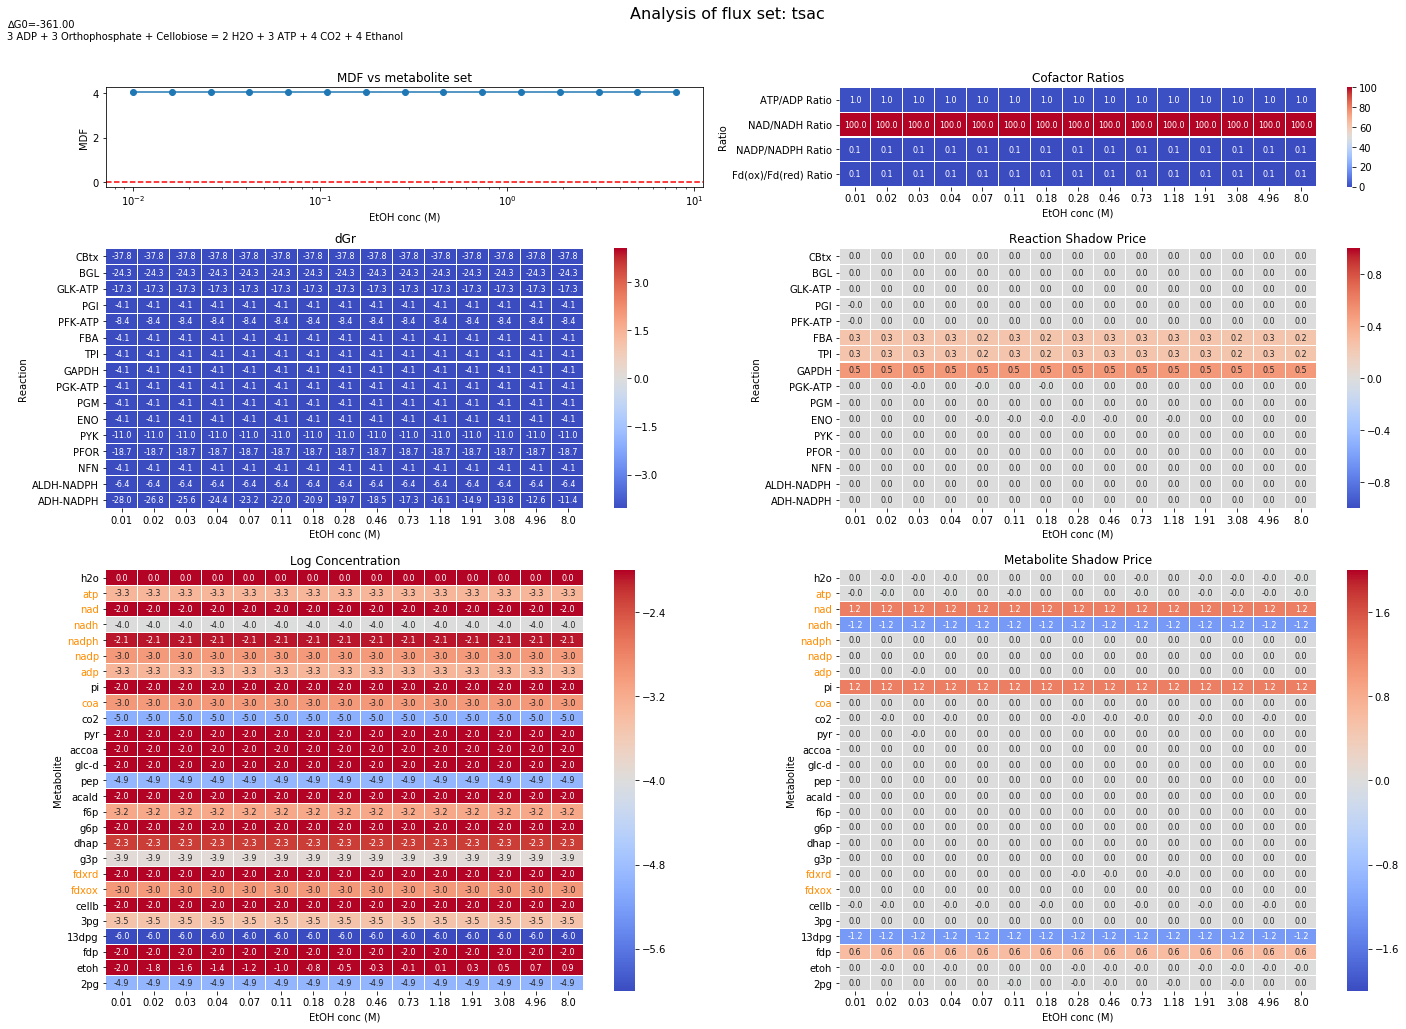

In [35]:
rm = ReactionMatcher() # for translating net reactions to plaintext
#fluxSets = ['ppi-pfk'] # for testing, when I don't want to run through all of the flux sets
#fluxSets = allRxnDf.loc[:,'ppi-pfk':'atp-pfk'].columns.values #for just testing a couple of flux sets
fluxSets = allRxnDf.loc[:,'ppi-pfk':].columns.values # for testing all flux sets

et_conc = np.geomspace(0.01, 8, 15) # 15 points geometrically spaced from 0.01 to 4
#et_conc = [1.0] # for testing a single concentration of ethanol
et_conc_rnd = [round(x, 2) for x in et_conc] # rounded for displaying labels on graph
netRxns = {} # dictionary to hold net reaction strings for each flux set

# make list of bounds to get from model
getBoundsFromModel = boundsDf.loc[boundsDf['Type'] == 'Cofactor', 'KEGG_ID'].values

for fluxSet in fluxSets:
    print('\n\n\n********* Working on flux set {} ************'.format(fluxSet))
    pp = make_pathway(fluxSet, allRxnDf)
    pp.bounds = set_model_bounds(pp.bounds.Copy(), modelBounds = getBoundsFromModel) # set cofactor concentrations based on 
                                                                                     #'metabolite_bounds' sheet from Excel model
    netRxns[fluxSet] = get_model_description(pp) # determine net reaction in plaintext

    # calculate the min-max driving force for different ethanol concentrations
    mdf_result = [] # store list of mdf_result objects, in case we want to inspect them later
    mdf_values = [] # store MDF values for making MDF vs. ethanol plot
    compoundDfList = [] # hold report_compounds dataframes
    rxnDfList = [] # hold report_reactions dataframes
    for idx, c in enumerate(et_conc):
        pp.bounds.SetBounds(atkDict['etoh'], c,c )
        result = pp.calc_mdf()
        #result.mdf_plot.show() # show MDF vs. reaction plot
        mdf_result.append(result)
        mdf_values.append(result.mdf)

        # clean up dataframe for compounds
        df = pd.DataFrame(result.report_compounds)
        df['mets'] = df['compound'].map(ktaDict)
        df.set_index('mets', drop = True, inplace = True)
        nadRatio = df.loc['nad', 'concentration'] / df.loc['nadh', 'concentration'] # calculate nadRatio
        mi = pd.MultiIndex.from_product([[et_conc_rnd[idx]], df.columns], names = ['et_conc', 'data'])
        df.columns = mi
        compoundDfList.append(df)

        # clean up dataframe for reactions
        df2 = pd.DataFrame(result.report_reactions)
        rxnIds = list(r.reaction_id for r in pp.reactions)
        df2['name'] = rxnIds
        df2.set_index('name', drop = True, inplace = True)
        mi2 = pd.MultiIndex.from_product([[et_conc_rnd[idx]], df2.columns], names = ['et_conc', 'data'])
        df2.columns = mi2
        rxnDfList.append(df2)
        
        print('ethanol conc = {:.2f}, NAD/NADH ratio = {:.2f}'.format(et_conc[idx], nadRatio))
        
        # for checking metabolite bounds
        #mets = compDf.loc[:,('compound', 0.01)].values
        #bDf = bounds_to_df(mets, pp.bounds)
        #display(bDf)
        

    # merge all of the report_compound dataframes into one big one
    # arrange the compound results in a dataframe to make plotting easy
    compDf = pd.concat(compoundDfList, axis=1)
    compDf = compDf.swaplevel(axis = 'columns')
    
    rxnDf = pd.concat(rxnDfList, axis=1)
    rxnDf = rxnDf.swaplevel(axis = 'columns')
    
    # plot the results
    myFig = make_plots(fluxSet, mdf_values, et_conc, 
                   compDf, rxnDf, netRxns, savePdf = True, xlabels = [], 
                   modelBounds = getBoundsFromModel, measuredBounds = [])